In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pytensor.tensor as at
import pytensor
floatX = pytensor.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

In [2]:
import emll
from emll.pytensor_utils import LeastSquaresSolve

In [3]:
os.chdir('../..')
from src import antemll, util_pytensor
os.chdir('notebooks/topologyC')

In [4]:
ant ='../../models/Antimony/TopologyC.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()


1.9044426622520472e-14

In [5]:
pt_levels = [0.5, 1.5]
pt_labels = ['0.5x', '1.5x']

In [6]:
data05 = pd.read_csv('../../data/interim/generated_data/topologyC_1/TopologyC_0.5.csv')
data15 = pd.read_csv('../../data/interim/generated_data/topologyC_1/TopologyC_1.5.csv')

print(data05.shape)

(69, 213)


In [8]:
BMCA_obj05 = antemll.antemll(ant, data05, cobra_sbml='../../models/sbml/TopologyC_cobra.xml')
BMCA_obj15 = antemll.antemll(ant, data15, cobra_sbml='../../models/sbml/TopologyC_cobra.xml')


../../models/Antimony/TopologyC_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_cobra.ant


No objective coefficients in model. Unclear what should be optimized


In [9]:
BMCA_obj05.xn = BMCA_obj05.xn.sample(frac=.5, axis=1)
BMCA_obj15.xn = BMCA_obj15.xn.sample(frac=.5, axis=1)

## Running ADVI

In [10]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sigma=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sigma=1, alpha=5))

        trace_prior = pm.sample_prior_predictive()

    return trace_prior

In [11]:
prior05 = run_prior_predictive(BMCA_obj05)
prior15 = run_prior_predictive(BMCA_obj15)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [12]:
def run_ADVI(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')

    known_chi_inds = []
    unknown_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in BMCA_obj.xn.columns:
            known_chi_inds.append(i)
        else: 
            unknown_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, unknown_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sigma=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sigma=1, alpha=5))

        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(unknown_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        pm.Deterministic('chi_t', chi_t)

        # Calculate steady-state concentrations and fluxes from elasticities
        chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, BMCA_obj.en.values, BMCA_obj.yn.values)
        
        # Error distributions for observed steady-state concentrations and fluxes
        chi_obs = pm.Normal('chi_obs', mu=chi_ss[:, known_chi_inds], sigma=0.05, observed=BMCA_obj.xn.values)
        v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss[:, 0].squeeze(),
                            sigma=0.05, observed=BMCA_obj.vn.squeeze())
        
        N_ITERATIONS = 150000

    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n= N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(1000)
        ppc_vi = pm.sample_posterior_predictive(trace)
    
    return trace, ppc_vi

Finished [100%]: Average Loss = 18,342
Sampling: [chi_measured, chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 62.405
Sampling: [chi_measured, chi_obs, v_hat_obs]


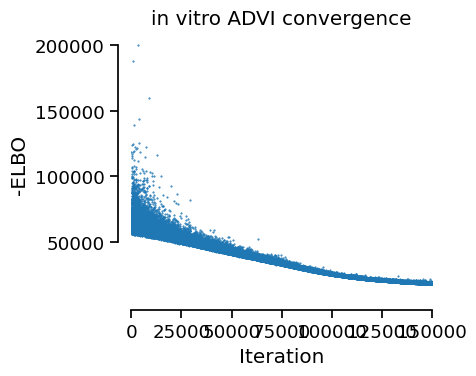

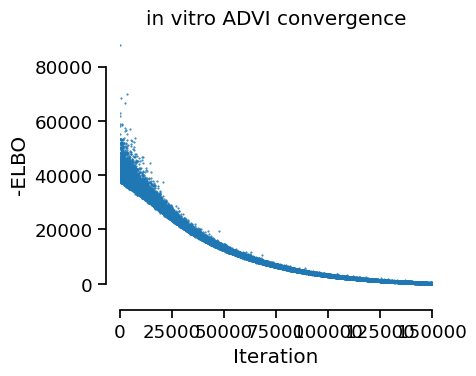

In [13]:
trace05, ppc05 = run_ADVI(BMCA_obj05)
trace15, ppc15 = run_ADVI(BMCA_obj15)

In [14]:
with gzip.open("topologyC_omitIntMet50_emll_traces_ppc.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "prior05": prior05,
                "prior15": prior15,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "trace05":trace05,
                "trace15":trace15,
                },
                f,
            )

## Analysis

In [13]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + "topologyC_omitIntMet50_emll_traces_ppc.pgz", "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [14]:
trace05 = traces['trace05']
trace15 = traces['trace15']

ppc05 = traces['ppc05']
ppc15 = traces['ppc15']

In [15]:
v_ppc05 = az.summary(ppc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc15 = az.summary(ppc15['posterior_predictive']['v_hat_obs'])['mean']

x_ppc05 = az.summary(ppc05['posterior_predictive']['chi_obs'])['mean']
x_ppc15 = az.summary(ppc15['posterior_predictive']['chi_obs'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [15]:
v_ppc05 = az.summary(ppc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc15 = az.summary(ppc15['posterior_predictive']['v_hat_obs'])['mean']

x_ppc05 = az.summary(ppc05['posterior_predictive']['chi_obs'])['mean']
x_ppc15 = az.summary(ppc15['posterior_predictive']['chi_obs'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


#### Known flux and metabolite concentrations check

Text(0.5, 0.98, 'BMCA on Topology C, 0.5x perturbation')

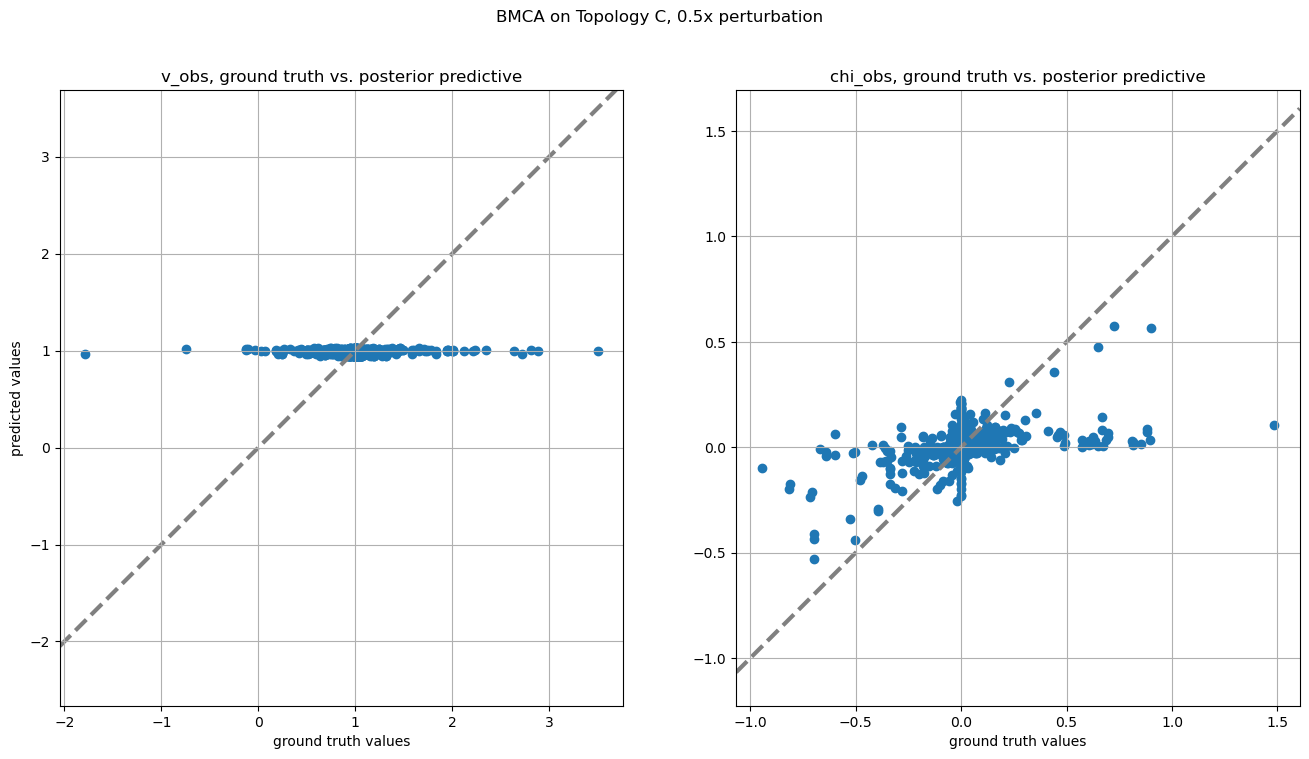

In [17]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.set_aspect('equal', 'datalim')
ax1.scatter(BMCA_obj05.vn.values, v_ppc05.values.reshape((68,-1)))
ax1.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax1.set_title('v_obs, ground truth vs. posterior predictive')
ax1.set_xlabel('ground truth values')
ax1.set_ylabel('predicted values')
ax1.grid()

ax2.set_aspect('equal', 'datalim')
ax2.scatter(BMCA_obj05.xn.values, x_ppc05.values.reshape((68,-1)))
ax2.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax2.set_title('chi_obs, ground truth vs. posterior predictive')
ax2.set_xlabel('ground truth values')
ax2.grid()

f.suptitle('BMCA on Topology C, 0.5x perturbation')

Text(0.5, 0.98, 'BMCA on Topology C, 1.5x perturbation')

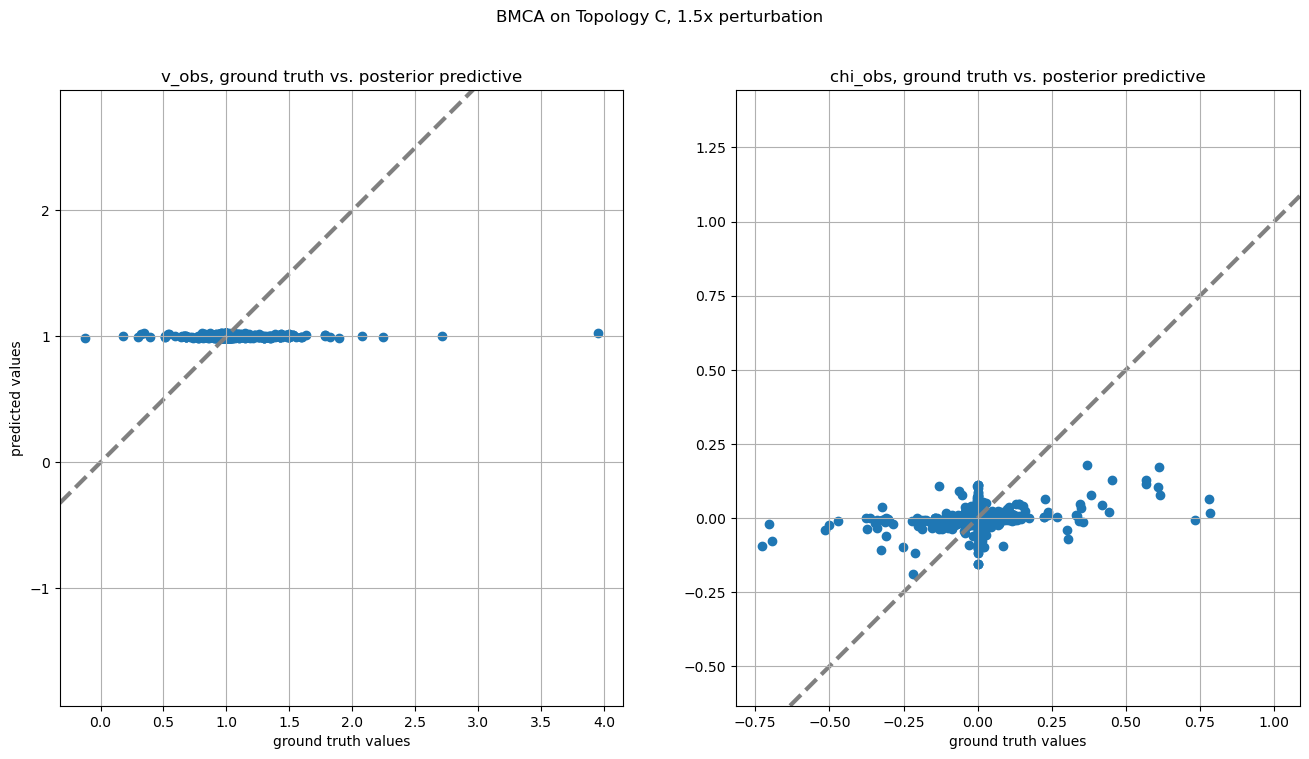

In [18]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.set_aspect('equal', 'datalim')
ax1.scatter(BMCA_obj15.vn.values, v_ppc15.values.reshape((68,-1)))
ax1.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax1.set_title('v_obs, ground truth vs. posterior predictive')
ax1.set_xlabel('ground truth values')
ax1.set_ylabel('predicted values')
ax1.grid()

ax2.set_aspect('equal', 'datalim')
ax2.scatter(BMCA_obj15.xn.values, x_ppc15.values.reshape((68,-1)))
ax2.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax2.set_title('chi_obs, ground truth vs. posterior predictive')
ax2.set_xlabel('ground truth values')
ax2.grid()

f.suptitle('BMCA on Topology C, 1.5x perturbation')

#### Elasticity check

In [16]:
Ex05_advi = util_pytensor.get_az_summary(trace05)
Ex15_advi = util_pytensor.get_az_summary(trace15)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [17]:
prior_Ex05_advi = az.summary(prior05['prior']['Ex'])['mean']
prior_Ex15_advi = az.summary(prior15['prior']['Ex'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [18]:
pt_labels= ['0.5x-pr', '1.5x-pr', '0.5x-post', '1.5x-post']

In [19]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                prior_Ex05_advi, prior_Ex15_advi, Ex05_advi, Ex15_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA_allData_elasticities.csv')

In [20]:
e_slopes = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

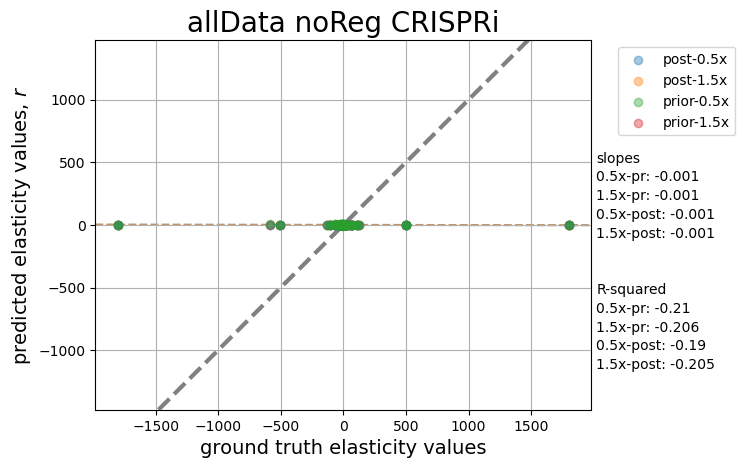

In [22]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-pr'], alpha=0.4, label='post-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-pr'], alpha=0.4, label='post-1.5x')

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-post'], alpha=0.4, label='prior-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-post'], alpha=0.4, label='prior-1.5x')


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2020
line_spacing = 150
slope_start = 500
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(2):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

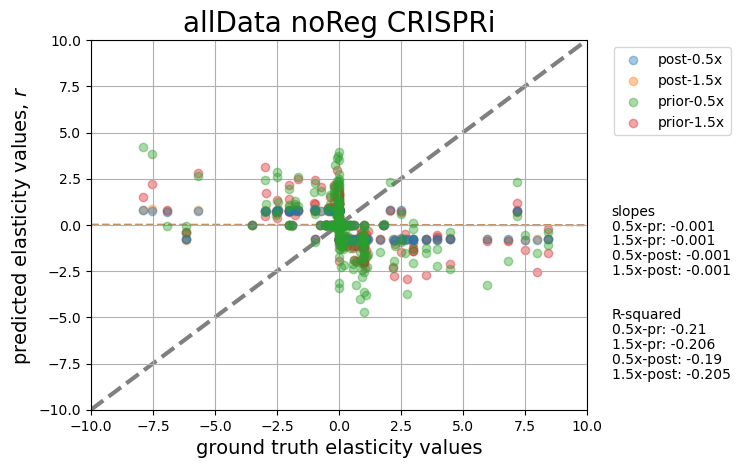

In [23]:
# plt.axes().set_aspect('equal', 'datalim')

plt.ylim(-10,10)
plt.xlim(-10,10)

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-pr'], alpha=0.4, label='post-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-pr'], alpha=0.4, label='post-1.5x')

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-post'], alpha=0.4, label='prior-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-post'], alpha=0.4, label='prior-1.5x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 11
line_spacing = 0.8
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(2):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)


In [26]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()
MAE

gt               0.000000
0.5x-pr      12713.610346
1.5x-pr      12713.738127
0.5x-post    12991.492821
1.5x-post    12847.091958
dtype: float64

In [ ]:
MAE.to_csv('../../data/results/MAE/topologyC_allData_emll50_MAE.csv')

## Calculating FCCs

In [26]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [27]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = pytensor.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


## Negative predictions

In [28]:
Ex05_prior = util.get_az_summary(prior05['prior']['Ex'])
Ex15_prior = util.get_az_summary(prior15['prior']['Ex'])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [29]:
priorFCC05 = estimate_CCs(BMCA_obj05, Ex05_prior.reshape((68,-1)))
priorFCC15 = estimate_CCs(BMCA_obj15, Ex15_prior.reshape((68,-1)))

postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((68,-1)))
postFCC15 = estimate_CCs(BMCA_obj15, Ex15_advi.reshape((68,-1)))

In [30]:
prior_FCCs = [priorFCC05, priorFCC15]
post_FCCs = [postFCC05, postFCC15]


In [31]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_priorFCCs = pd.concat([append_FCC_df(prior_FCCs[i], pt_labels[i]) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([append_FCC_df(post_FCCs[i], pt_labels[i]) for i in range(len(post_FCCs))])

In [33]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
medPrdFCCs.head()

,,vPGI,vPFK,vFBA,vTPI,vGDH,vPGK,vGPM,vENO,vPYK,vZWF,...,vNDHII,vGROWTH,vATP_MAINTENANCE,vXCH_GLC,vPIT,vXCH_P,vXCH_ACE1,v_ACE_OUT,vXCH_ACE2,vGL6P_HYDROLYSIS
pt_rxn,pt_str,,,,,,,,,,,,,,,,,,,,,
vPGI,0.5x,-1.968820,0.033067,0.031088,0.029251,0.044486,0.030443,0.023929,0.029408,0.024537,0.001870,...,0.047380,0.015540,0.028515,0.022129,0.039210,0.034182,0.000992,-0.000203,-0.000788,4.042817e-10
vPFK,0.5x,0.021455,-1.969175,0.026992,0.025475,0.042002,0.029051,0.021475,0.027032,0.022766,0.003431,...,0.043863,0.015600,0.026464,0.020369,0.036937,0.032040,0.001137,-0.000393,-0.000743,2.219006e-09
vFBA,0.5x,0.021610,0.030675,-1.972692,0.025556,0.041913,0.028996,0.021456,0.027057,0.022815,0.003412,...,0.043826,0.015629,0.026444,0.020380,0.037188,0.032200,0.001101,-0.000372,-0.000727,2.212497e-09
vTPI,0.5x,0.021610,0.030675,0.027308,-1.974444,0.041913,0.028996,0.021456,0.027057,0.022815,0.003412,...,0.043826,0.015629,0.026444,0.020380,0.037188,0.032200,0.001101,-0.000372,-0.000727,2.212497e-09
vGDH,0.5x,0.017458,0.026476,0.020792,0.019139,-1.958495,0.027946,0.018385,0.024256,0.017608,0.005783,...,0.042439,0.017499,0.024742,0.019634,0.037419,0.031971,0.000947,-0.000279,-0.000667,4.298170e-09


## Evaluating FCC ranking

In [32]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v_ACE_OUT']

In [33]:
def calculate_FCC_med_rankings(postFCC, reaction='v_ACE_OUT'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

### via Spearman rank coefficients

In [34]:
from scipy.stats import spearmanr

def bootstrap_spearman(x, y, num_bootstrap=1000, alpha=0.05):
    n = len(x)
    corr_list = []

    # Original Spearman correlation
    corr_original, p_value = spearmanr(x, y)

    for _ in range(num_bootstrap):
        # Generate bootstrap samples
        indices = np.random.randint(0, n, n)
        x_bootstrap = [x[i] for i in indices]
        y_bootstrap = [y[i] for i in indices]

        # Calculate Spearman correlation for the bootstrap sample
        corr, _ = spearmanr(x_bootstrap, y_bootstrap)
        corr_list.append(corr)

    # Convert to numpy array for convenience
    corr_list = np.array(corr_list)
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(corr_list, (alpha/2) * 100)
    upper_bound = np.percentile(corr_list, (1 - alpha/2) * 100)
    
    return corr_original, p_value, lower_bound, upper_bound

In [42]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


C:\Users\user\AppData\Local\Temp\ipykernel_28632\249619954.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\user\AppData\Local\Temp\ipykernel_28632\249619954.py:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [43]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.5x,0.261433,0.03260,-0.007976,0.498054
1.5x,0.144864,0.24215,-0.139492,0.384847


In [44]:
spearman_df.to_csv('topologyC_emll_spr.csv')

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top 10 rankings

In [35]:
pt_labels= ['0.5x-pr', '1.5x-pr', '0.5x-post', '1.5x-post']

In [36]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v_ACE_OUT') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v_ACE_OUT')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

,gt,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
v_ACE_OUT,,,,,
1.0,vACS,vXCH_ACE2,vXCH_ACE2,vXCH_ACE2,vXCH_ACE2
2.0,vGLT,vXCH_ACE1,vXCH_ACE1,vXCH_ACE1,vXCH_ACE1
3.0,vACK,vATP_MAINTENANCE,vATP_MAINTENANCE,vGDH,vACS
4.0,vGLC_feed,vCYTBO,vACK,vCYTBO,vACK
5.0,vATP_MAINTENANCE,vPTA,vADK,vGLT,vADK
...,...,...,...,...,...
64.0,vGL6P_HYDROLYSIS,vACEK_1,vPPS,vX5P_GAP_TKT,vPTS_1
65.0,vPTS_4,vPPS,vEDA,vPPS,vPPS
66.0,vPTS_3,vFBP,vFBP,vFBP,vFBP


In [37]:
q.to_csv('topologyC_emll50_rankings.csv')

In [38]:
rank_df = pd.read_csv('topologyC_emll50_rankings.csv')

In [39]:
topTen_df = rank_df[rank_df['v_ACE_OUT'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results

,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
0,4,5,4,5


In [40]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Index([22, 33, 42, 43, 50, 51], dtype='int64')
Index([22, 33, 42, 43, 50], dtype='int64')
Index([17, 18, 19, 22, 42, 43], dtype='int64')
Index([12, 33, 42, 43, 48], dtype='int64')
